# Anime Recommendation Program Project  

#### Data Mining Project  


#### Kerry Gip

## Import Libraries 

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import re
import string
from math import *
from collections import Counter
from typing import Dict, Text

#graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

#system libraries
import os
import statistics
from datetime import datetime

#fuzzy matching 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process


#recommenders
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#surprise
from surprise import Dataset,SVD,Reader
from surprise import KNNBasic
from surprise import accuracy
from surprise.model_selection import cross_validate

#tensorflow
import tensorflow as tf
import tensorflow_recommenders as tfrs

#visualizations 
from wordcloud import WordCloud

#visual output aid 
pd.set_option('max_colwidth', 800)

#because why not
import warnings
warnings.filterwarnings('ignore')

## Reading In Data

In [2]:
#https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020
myanimelist_dataset2020 = pd.read_csv("Data/MALanime2020.csv") 
#myanimelist_dataset2020.shape[0] = 17562
myanimelist_ratings2020 = pd.read_csv("Data/MALanime_Ratings2020.csv") 
# myanimelist_ratings2020.shape[0] =  57633278 <-- lol damn son 


#https://www.kaggle.com/datasets/vishalmane10/anime-dataset-2022
animeplanet_dataset2022 = pd.read_csv("Data/APanime2022.csv")
#animeplanet_dataset2022.shape[0] = 18495

# https://www.kaggle.com/datasets/sekian/nhentai
nhentai_dataset2020 = pd.read_csv("Data/nHentai2020.csv")
nHentai_Tags2020 = pd.read_csv("Data/nHentai_Tags2020.csv")

In [3]:
myanimelist_dataset2020.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
myanimelist_ratings2020.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [5]:
animeplanet_dataset2022.head()

,Rank,Name,Japanese_name,Type,Episodes,Studio,Release_season,Tags,Rating,Release_year,End_year,Description,Content_Warning,Related_Mange,Related_anime,Voice_actors,staff
0,1,Demon Slayer: Kimetsu no Yaiba - Entertainment District Arc,Kimetsu no Yaiba: Yuukaku-hen,TV,NaN,ufotable,Fall,"Action, Adventure, Fantasy, Shounen, Demons, Historical, Martial Arts, Orphans, Siblings, Swordplay, Based on a Manga, Explicit Violence",4.60,2021.0,NaN,"'Tanjiro and his friends accompany the Hashira Tengen Uzui to an entertainment district where Tengen’s female ninja agents were gathering information on a demon before they suddenly disappeared. In order to investigate, Tanjiro and the others disguise themselves as women to sneak in!'",Explicit Violence,Demon Slayer: Kimetsu no Yaiba,"Demon Slayer: Kimetsu no Yaiba, Demon Slayer: Kimetsu no Yaiba Movie - Mugen Train, Demon Slayer: Kimetsu no Yaiba - Mugen Train","Inosuke Hashibira : Yoshitsugu Matsuoka, Nezuko Kamado : Akari Kitou, Tanjirou Kamado : Natsuki Hanae, Zenitsu Agatsuma : Hiro Shimono, Daki : Miyuki Sawashiro, Tengen Uzui : Katsuyuki Konishi, Akaza : Akira Ishida, Amane Ubuyashiki, Koyoharu Gotouge\nOriginal Creator, Haruo Sotozaki\nDirector, Akira Matsushima\nCharacter Design, Aimer\nSong Performance","Koyoharu Gotouge : Original Creator, Haruo Sotozaki : Director, Akira Matsushima : Character Design, Aimer : Song Performance"
1,2,Fruits Basket the Final Season,Fruits Basket the Final,TV,13.0,TMS Entertainment,Spring,"Drama, Fantasy, Romance, Shoujo, Animal Transformation, Contemporary Fantasy, Curse, Dysfunctional Families, Mental Illness, Orphans, Based on a Manga, Emotional Abuse,, Mature Themes,, Physical Abuse,, Suicide,, Violence,, Domestic Abuse",4.60,2021.0,NaN,'The final arc of Fruits Basket.',"Emotional Abuse,, Mature Themes,, Physical Abuse,, Suicide,, Violence,, Domestic Abuse","Fruits Basket, Fruits Basket Another","Fruits Basket 1st Season, Fruits Basket 2nd Season","Akito Sohma : Maaya Sakamoto, Kyo Sohma : Yuuma Uchida, Shigure Sohma : Yuuichi Nakamura, Tohru Honda : Manaka Iwami, Yuki Sohma : Nobunaga Shimazaki, Arisa Uotani : Atsumi Tanezaki, Hatsuharu Sohma : Makoto Furukawa, Isuzu Sohma : Aki Toyosaki, Natsuki Takaya\nOriginal Creator, Yoshihide Ibata\nDirector & Episode Director & Storyboard, Taku Kishimoto\nScreenplay & Series Composition, Masaru Yokoyama\nMusic, Masaru Shindou\nCharacter Design & Chief Animation Director, Baek-Ryun Chae\nPhotography Director, Youko Koyama\nArt Director, Mika Sugawara\nColor Design","Natsuki Takaya : Original Creator, Yoshihide Ibata : Director & Episode Director & Storyboard, Taku Kishimoto : Screenplay & Series Composition, Masaru Yokoyama : Music, Masaru Shindou : Character Design & Chief Animation Director, Baek-Ryun Chae : Photography Director, Youko Koyama : Art Director, Mika Sugawara : Color Design"
2,3,Mo Dao Zu Shi 3,The Founder of Diabolism 3,Web,12.0,B.C MAY PICTURES,NaN,"Fantasy, Ancient China, Chinese Animation, Cultivation, Xianxia, Based on a Web Novel",4.58,2021.0,NaN,'The third season of Mo Dao Zu Shi.',NaN,"Grandmaster of Demonic Cultivation: Mo Dao Zu Shi (Novel), The Master of Diabolism","Mo Dao Zu Shi 2, Mo Dao Zu Shi Q","Lan Wangji, Wei Wuxian, Jiang Cheng, Jin Guangyao, Jin Ling, Lan Jingyi, Lan Sizhui, Lan Xichen, Mo Xiang Tong Xiu\nOriginal Creator, Xiong Ke\nChief Director, Ma Chendi\nChief Director, Sun Yujing\nMusic, Weng Teng\nMusic, Feng Shuo\nMusic, Shen Lin\nCharacter Design & Chief Animation Director, Liang Sha\nScreenplay","Mo Xiang Tong Xiu : Original Creator, Xiong Ke : Chief Director, Ma Chendi : Chief Director, Sun Yujing : Music, Weng Teng : Music, Feng Shuo : Music, Shen Lin : Character Design & Chief Animation Director, Liang Sha : Screenplay"
3,4,Fullmetal Alchemist: Brotherhood,Hagane no Renkinjutsushi: Full Metal Alchemist,TV,64.0,Bones,Spring,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, M

In [6]:
nhentai_dataset2020.head()

,id,media_id,upload_date,tags,num_pages,num_favorites,title.english,title.japanese,title.pretty
0,1,9,1403964736,5452;6346;9063;19440;24876;28227;30657;31386;33172;60274,14,83,(C71) [Arisan-Antenna (Koari)] Eat The Rich! (Sukatto Golf Pangya),(C71) [ありさんアンテナ (小蟻)] Eat The Rich! (スカッとゴルフ パンヤ),Eat The Rich!
1,2,136,1403964736,10314;7882;33172;27553;21278;20502;17701;17249;16576;12227;9304;8011;2937,55,122,"(C68) [Toko-ya (HEIZO, Kitoen)] Manatsu no Oni (Higurashi no Naku Koro ni) [English]",(C68) [床子屋 (HEIZO、鬼頭えん)] 真夏のオニ (ひぐらしのなく頃に) [英訳],Manatsu no Oni
2,3,254,1403964737,976;6346;7718;8010;11920;13159;13552;29859;32341;33172,18,42,(C68) [Kashiwa-Ya (Hiyo Hiyo)] Sakurasaku Heisei Juunana Nen (Naruto),(C68) [かしわ屋 (ひよひよ)] サクラサク平成十七年 (ナルト),Sakurasaku Heisei Juunana Nen
3,4,290,1403964737,2937;4314;6346;7706;11430;13159;14971;16298;19954;22942;25439;29859;31787;33172,31,20,"(C67) [Shikisokuzekuu (Shake, Kuma)] Honey Bunny (Naruto)",(C67) [色即是空 (しゃけ、くま)] Honey Bunny (ナルト),Honey Bunny
4,5,465,1403964737,50834;33172;6346;29013;27553;21779;20525;19440;17749;17137;16332;11248;10173;8653;8378,68,39,"(C66) [HENREIKAI (Karashima Hiroyuki, Kawarajima Kou, Urushihara Satoshi)] Ayanami Club 3 (Evangelion, Keroro Gunsou)","(C66) [片励会 (からしまひろゆき, かわらじま晃, うるし原智志)] 綾波倶楽部参 (新世紀エヴァンゲリオン, ケロロ軍曹)",Ayanami Club 3


In [7]:
nHentai_Tags2020.head()

,id,type,name,url,count
0,190,tag,maid,/tag/maid/,10212
1,370,tag,business suit,/tag/business-suit/,2955
2,560,tag,twins,/tag/twins/,1462
3,584,artist,momofuki rio,/artist/momofuki-rio/,102
4,657,artist,somejima,/artist/somejima/,206


## Clean the Data/ ETL

#### 1. Fixing the little nuances in labeling

#### 2. Convert data for consistency within the datasets (Float -> Int, List format to "," format, etc) 

#### 3. Checking for NULLS

#### 4. Fill in NULLS with mean if int column or some string

#### 5. Drop Duplicates

#### 6. Fuzzy Match/Merge the data sets and see if we can negate the nulls in the data based on same columns   


 
 
 
 

In [8]:
mal_list = []
ap_list = []
hentai_list = []

count = 0

for col in myanimelist_dataset2020.columns:
    mal_list.append(col)
    count = count +1
    
    
for col in animeplanet_dataset2022.columns:
    ap_list.append(col)
    
for col in nhentai_dataset2020.columns:
    hentai_list.append(col)
    
print(mal_list)
print(count)
print("\n\n", ap_list)
print("\n\n", hentai_list)

['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name', 'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1']
35


 ['Rank', 'Name', 'Japanese_name', 'Type', 'Episodes', 'Studio', 'Release_season', 'Tags', 'Rating', 'Release_year', 'End_year', 'Description', 'Content_Warning', 'Related_Mange', 'Related_anime', 'Voice_actors', 'staff']


 ['id', 'media_id', 'upload_date', 'tags', 'num_pages', 'num_favorites', 'title.english', 'title.japanese', 'title.pretty']


#### So we can see here that in the my anime list dataset, they didn't capitalize the column names. Also going between them, we can see that they have different column labels (i.e genre vs Tags). So lets go through that. Annoyingly  

Anime Planet is the most recent one at 2022, so we will match the column names to match as much as we can to AP  

And for my own personal preference, I want to reaarange them so the columns line up and match as much as they can 

Also going through and checking to see what columns exist and are just obscurely named  

I see that premiered is season-year, the same as Release Season and Release Year in 2022 data, so lets split it up to match
the data

In [9]:
#checking for a producers column in AP data 

#animeplanet_dataset.apply(lambda row: row.astype(str).str.contains('TV Tokyo'), axis=1)
animeplanet_dataset2022[animeplanet_dataset2022.apply(lambda row: row.astype(str).str.contains("TV Tokyo", case=False).any(), axis=1)]

,Rank,Name,Japanese_name,Type,Episodes,Studio,Release_season,Tags,Rating,Release_year,End_year,Description,Content_Warning,Related_Mange,Related_anime,Voice_actors,staff


In [10]:
#splitting the premiered from Fall 2020 to separate columns 

new = myanimelist_dataset2020["Premiered"].str.split(" ", n = 1, expand = True)

myanimelist_dataset2020["Release Season"]= new[0]
 
myanimelist_dataset2020["Release Year"]= new[1]


In [11]:
#Renaming
myanimelist_dataset2020.columns = ['MAL_ID', 'Name', 'Score', 'Tags', 'English Name', 'Japanese Name', 'Type', 'Episodes', 
                               'Aired', 'Premiered', 'Producers', 'Licensors', 'Studio', 'Source', 'Duration', 'Rating', 
                               'Ranked', 'Popularity', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 
                               'Dropped', 'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 
                               'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', "Release Season", "Release Year"]


#Reordering the columns 
myanimelist_dataset2020 = myanimelist_dataset2020[["MAL_ID", "Name", "English Name", "Japanese Name", "Type", "Episodes", "Studio",
                                          "Release Season", "Release Year", "Tags", "Score", "Rating", "Ranked", 'Aired', 
                                           'Producers', 'Licensors', 'Source', 'Duration', 'Popularity', 'Members',
                                           'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch',
                                           'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4',
                                           'Score-3', 'Score-2', 'Score-1']]
                                           

In [12]:
myanimelist_dataset2020["Score"]

0           8.78
1           8.39
2           8.24
3           7.27
4           6.98
          ...   
17557    Unknown
17558    Unknown
17559    Unknown
17560    Unknown
17561    Unknown
Name: Score, Length: 17562, dtype: object

In [13]:
#Renaming
myanimelist_ratings2020.columns = ["User_ID", "MAL_ID", "Rating"]

In [14]:
#need to rename Rating since it has the actual R-17 or whatever 
myanimelist_dataset2020["Rating"]

0        R - 17+ (violence & profanity)
1        R - 17+ (violence & profanity)
2             PG-13 - Teens 13 or older
3             PG-13 - Teens 13 or older
4                         PG - Children
                      ...              
17557                           Unknown
17558                           Unknown
17559    R - 17+ (violence & profanity)
17560         PG-13 - Teens 13 or older
17561                           Unknown
Name: Rating, Length: 17562, dtype: object

In [15]:
#renaming 
myanimelist_dataset2020.rename(columns={"Rating": "Category"}, inplace = True)

In [16]:
myanimelist_ratings2020["Rating"]

0           9
1           5
2           7
3           7
4           9
           ..
57633273    8
57633274    4
57633275    8
57633276    7
57633277    7
Name: Rating, Length: 57633278, dtype: int64

In [17]:
#Renaming
animeplanet_dataset2022.columns = ['Rank', 'Name', 'Japanese Name', 'Type', 'Episodes', 'Studio', 'Release Season', 'Tags', 
                               'Rating', 'Release Year', 'End Year', 'Description', 'Content Warning', 'Related Manga', 
                               'Related Anime', 'Voice Actors', 'Staff']

#Reordering
animeplanet_dataset2022 = animeplanet_dataset2022[['Rank', 'Name', 'Japanese Name', 'Type', 'Episodes', 'Studio', 'Release Season',
                                           'Release Year', 'Tags', 'Rating', 'End Year', 'Description', 'Content Warning', 
                                           'Related Manga', 'Related Anime', 'Voice Actors', 'Staff']]


In [18]:
print("MAL data", myanimelist_dataset2020.shape[0])
print("MAL Ratings", myanimelist_ratings2020.shape[0])

MAL data 17562
MAL Ratings 57633278


In [19]:
#Merging and only preserving the og dataset
mal2020_fat_demo = myanimelist_dataset2020.merge(myanimelist_ratings2020, how ="inner", on = "MAL_ID")

#idk why when merging on Left, it changed Rating to Rating_y, so we're renaming it here
#mal2020 = mal2020.rename(columns={"Rating_y": "Rating"})
mal2020_fat_demo.head()

,MAL_ID,Name,English Name,Japanese Name,Type,Episodes,Studio,Release Season,Release Year,Tags,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,User_ID,Rating
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,3,9
1,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,6,6
2,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,14,9
3,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,19,8
4,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,22,9


In [20]:
#Mal Ratings is huge, its been giving me a lot of issues when running so, the issue is that with mal2020, the ratings 
#are all separted based on user. So what I should do is groupby the ratings to get an average score and then merge it again
#on MAL_ID
#ooooh boy does that look much better 
new_ratings = myanimelist_ratings2020.groupby([ "MAL_ID"])["Rating"].mean().reset_index()
new_ratings

,MAL_ID,Rating
0,1,8.763003
1,5,8.318865
2,6,8.243815
3,7,7.409233
4,8,7.150594
...,...,...
16867,47614,7.142857
16868,47616,4.657550
16869,47618,5.187500
16870,48177,5.909091


In [21]:
#remerge it 
mal2020 = myanimelist_dataset2020.merge(new_ratings, how ="inner", on = "MAL_ID")


In [22]:
#checking these two out and if they either A, need an average or B just dropped since they're the same
mal2020[["Rating", "Score"]]

,Rating,Score
0,8.763003,8.78
1,8.318865,8.39
2,8.243815,8.24
3,7.409233,7.27
4,7.150594,6.98
...,...,...
16867,7.142857,6.83
16868,4.657550,4.81
16869,5.187500,Unknown
16870,5.909091,Unknown


In [23]:
mal2020["Average Rating"] = mal2020[["Rating", "Score"]].mean(axis = 1)

In [24]:
mal2020.head()

,MAL_ID,Name,English Name,Japanese Name,Type,Episodes,Studio,Release Season,Release Year,Tags,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Rating,Average Rating
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,8.763003,8.763003
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,Bones,Unknown,None,"Action, Drama, Mystery, Sci-Fi, Space",...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,8.318865,8.318865
2,6,Trigun,Trigun,トライガン,TV,26,Madhouse,Spring,1998,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,8.243815,8.243815
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,Sunrise,Summer,2002,"Action, Mystery, Police, Supernatural, Drama, Magic",...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7.409233,7.409233
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,TV,52,Toei Animation,Fall,2004,"Adventure, Fantasy, Shounen, Supernatural",...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,7.150594,7.150594


In [25]:
#now we can remove these since we have the avg
mal2020.drop(columns = ["Rating", "Score"], axis = 1, inplace = True)
mal2020

,MAL_ID,Name,English Name,Japanese Name,Type,Episodes,Studio,Release Season,Release Year,Tags,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Average Rating
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26,Sunrise,Spring,1998,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",...,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,8.763003
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,Bones,Unknown,None,"Action, Drama, Mystery, Sci-Fi, Space",...,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,8.318865
2,6,Trigun,Trigun,トライガン,TV,26,Madhouse,Spring,1998,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",...,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,8.243815
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,Sunrise,Summer,2002,"Action, Mystery, Police, Supernatural, Drama, Magic",...,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7.409233
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,TV,52,Toei Animation,Fall,2004,"Adventure, Fantasy, Shounen, Supernatural",...,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,7.150594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16867,47614,Nu Wushen de Canzhuo Spring Festival Special,Cooking with Valkyries Spring Festival Special,Unknown,Special,1,Unknown,Unknown,None,"Slice of Life, Comedy",...,17.0,16.0,29.0,26.0,10.0,1.0,Unknown,3.0,Unknown,7.142857
16868,47616,Yakusoku no Neverland 2nd Season: Michishirube,The Promised Neverland Season 2 Episode 5.5,約束のネバーランド 特別編「道標」,Special,1,CloverWorks,Unknown,None,"Mystery, Psychological, Supernatural, Thriller, Shounen",...,141.0,317.0,565.0,998.0,1542.0,831.0,516.0,336.0,722.0,4.657550
16869,47618,Ichi Nichi Shite Narazu,Unknown,一日にして成らず,ONA,1,GEEK TOYS,Unknown,None,Slice of Life,...,Unknown,1.0,2.0,6.0,16.0,2.0,Unknown,1.0,1.0,5.187500
16870,48177,Ichiban Chikakute Tooi Hoshi,Unknown,一番近くて遠い星,ONA,1,Flat Studio,Unknown,None,"Music, Drama",...,Unknown,3.0,11.0,11.0,10.0,1.0,1.0,Unknown,Unknown,5.909091


In [26]:
#MERGING FOR A DIFFERNT PROCESS ALGORITHM - SURPRISE FILTERING 

mal_ratings = myanimelist_ratings2020[myanimelist_ratings2020['Rating'] != -1]

named_ratings = mal_ratings.merge(myanimelist_dataset2020[["MAL_ID", "Name"]], on = "MAL_ID")
named_ratings

,User_ID,MAL_ID,Rating,Name
0,0,430,9,Fullmetal Alchemist: The Conqueror of Shamballa
1,6,430,8,Fullmetal Alchemist: The Conqueror of Shamballa
2,18,430,10,Fullmetal Alchemist: The Conqueror of Shamballa
3,19,430,8,Fullmetal Alchemist: The Conqueror of Shamballa
4,33,430,4,Fullmetal Alchemist: The Conqueror of Shamballa
...,...,...,...,...
57633273,315549,38853,1,Ex-Arm
57633274,350024,38853,10,Ex-Arm
57633275,311855,39435,6,Oshiri Tantei Movie 1: Curry Naru Jiken
57633276,334473,35746,4,6 Lovers


In [27]:
#Shows how many times the user has rated something 
named_ratings.groupby('User_ID').count()['Rating'].sort_values(ascending=False).reset_index()

,User_ID,Rating
0,189037,15455
1,162615,14864
2,68042,13462
3,283786,12778
4,259790,9996
...,...,...
310054,201316,1
310055,201300,1
310056,97555,1
310057,201293,1


In [28]:
#Shows how many times the user has rated something and getting the most active members
activity = named_ratings.groupby('User_ID').count()['Rating'] >= 500
active_members = activity[activity].index
active_members

Int64Index([    17,     19,     42,    111,    112,    146,    156,    172,
               198,    222,
            ...
            353300, 353304, 353311, 353318, 353325, 353326, 353328, 353365,
            353395, 353398],
           dtype='int64', name='User_ID', length=23004)

In [29]:
#keeping popular anime names based on user ratings 

filtered_rating = named_ratings[named_ratings['User_ID'].isin(active_members)]
filtered_rating

,User_ID,MAL_ID,Rating,Name
3,19,430,8,Fullmetal Alchemist: The Conqueror of Shamballa
19,156,430,3,Fullmetal Alchemist: The Conqueror of Shamballa
21,172,430,4,Fullmetal Alchemist: The Conqueror of Shamballa
23,198,430,9,Fullmetal Alchemist: The Conqueror of Shamballa
40,314,430,6,Fullmetal Alchemist: The Conqueror of Shamballa
...,...,...,...,...
57633267,283786,45448,6,Dou Hun Wei Zhi Xuan Yue Qiyuan IV
57633268,283786,42465,6,Guan Hai Ce Zhi Tie Qi Xiong Guan
57633269,289506,41277,4,Rainbow Ruby
57633271,308285,40389,8,Uchuu Senkan Yamato 2205: Aratanaru Tabidachi


In [30]:
#now filtering most popular animes 
most_popular_filter = filtered_rating.groupby('MAL_ID').count()['Rating'] >= 500
popular_anime = most_popular_filter[most_popular_filter].index

In [31]:
surprise_filter = filtered_rating[filtered_rating['MAL_ID'].isin(popular_anime)].dropna().drop_duplicates()
surprise_filter

,User_ID,MAL_ID,Rating,Name
3,19,430,8,Fullmetal Alchemist: The Conqueror of Shamballa
19,156,430,3,Fullmetal Alchemist: The Conqueror of Shamballa
21,172,430,4,Fullmetal Alchemist: The Conqueror of Shamballa
23,198,430,9,Fullmetal Alchemist: The Conqueror of Shamballa
40,314,430,6,Fullmetal Alchemist: The Conqueror of Shamballa
...,...,...,...,...
57405335,351069,12935,6,Utakata Hanabi
57405336,351576,12935,7,Utakata Hanabi
57405337,351696,12935,7,Utakata Hanabi
57405338,351801,12935,6,Utakata Hanabi


In [32]:
#upload Date is a unix timestamp
#num pages is the gallery page number
#Renaming
nhentai_dataset2020.columns = ['ID', 'Media_ID', 'Upload Date', 'Tags', 'Num Pages', 'Num Favorites', 'English Name(Ugly)', 'Japanese Name', 'English Name']

#Reordering
nhentai_dataset2020 = nhentai_dataset2020[['ID', 'Media_ID','Num Favorites', 'English Name(Ugly)', 'English Name', 'Japanese Name']]

In [33]:
#Renaming
nHentai_Tags2020.columns = ["ID", "Type", "Tags", "URL", "Count"]

In [34]:
nhentai_dataset2020.shape[0]

294900

In [35]:
nHentai_Tags2020.shape[0]

66474

In [36]:
#just to be abundantly sure about the merge and that we don't have the same issue as the MAL dataset 
pervy_ratings = nHentai_Tags2020.groupby("ID").count().reset_index()
pervy_ratings[pervy_ratings["Count"] > 1]

,ID,Type,Tags,URL,Count


In [37]:
#Merging and only preserving the og dataset
nHentai = pd.merge(nhentai_dataset2020, nHentai_Tags2020, how ="left", on = "ID")
nHentai.head()

,ID,Media_ID,Num Favorites,English Name(Ugly),English Name,Japanese Name,Type,Tags,URL,Count
0,1,9,83,(C71) [Arisan-Antenna (Koari)] Eat The Rich! (Sukatto Golf Pangya),Eat The Rich!,(C71) [ありさんアンテナ (小蟻)] Eat The Rich! (スカッとゴルフ パンヤ),group,mu-keikaku,/group/mu-keikaku/,5.0
1,2,136,122,"(C68) [Toko-ya (HEIZO, Kitoen)] Manatsu no Oni (Higurashi no Naku Koro ni) [English]",Manatsu no Oni,(C68) [床子屋 (HEIZO、鬼頭えん)] 真夏のオニ (ひぐらしのなく頃に) [英訳],group,minors escort,/group/minors-escort/,9.0
2,3,254,42,(C68) [Kashiwa-Ya (Hiyo Hiyo)] Sakurasaku Heisei Juunana Nen (Naruto),Sakurasaku Heisei Juunana Nen,(C68) [かしわ屋 (ひよひよ)] サクラサク平成十七年 (ナルト),artist,kitazato futaba,/artist/kitazato-futaba/,1.0
3,4,290,20,"(C67) [Shikisokuzekuu (Shake, Kuma)] Honey Bunny (Naruto)",Honey Bunny,(C67) [色即是空 (しゃけ、くま)] Honey Bunny (ナルト),group,kuro food,/group/kuro-food/,2.0
4,5,465,39,"(C66) [HENREIKAI (Karashima Hiroyuki, Kawarajima Kou, Urushihara Satoshi)] Ayanami Club 3 (Evangelion, Keroro Gunsou)",Ayanami Club 3,"(C66) [片励会 (からしまひろゆき, かわらじま晃, うるし原智志)] 綾波倶楽部参 (新世紀エヴァンゲリオン, ケロロ軍曹)",artist,yoshiki,/artist/yoshiki/,29.0


In [38]:
nHentai.shape[0]

294900

# The Three DataFrames That I Am Working With  

nHentai  
mal2020  
animeplanet_dataset2022  

PLUS the one off so I can try out Surprise  
surprise_filter  

#### Now that we have fixed the little things, time to check for NULLS

In [39]:
mal2020.isnull().sum()

MAL_ID                0
Name                  0
English Name          0
Japanese Name         0
Type                  0
Episodes              0
Studio                0
Release Season        0
Release Year      12321
Tags                  0
Category              0
Ranked                0
Aired                 0
Producers             0
Licensors             0
Source                0
Duration              0
Popularity            0
Members               0
Favorites             0
Watching              0
Completed             0
On-Hold               0
Dropped               0
Plan to Watch         0
Score-10              0
Score-9               0
Score-8               0
Score-7               0
Score-6               0
Score-5               0
Score-4               0
Score-3               0
Score-2               0
Score-1               0
Average Rating        0
dtype: int64

In [40]:
animeplanet_dataset2022.isnull().sum()

Rank                   0
Name                   0
Japanese Name      10557
Type                   0
Episodes            8994
Studio              6477
Release Season     14379
Release Year         383
Tags                 400
Rating              3131
End Year           15641
Description            4
Content Warning    16655
Related Manga      10868
Related Anime       8432
Voice Actors        3186
Staff               5490
dtype: int64

In [41]:
nHentai.isnull().sum()

ID                         0
Media_ID                   0
Num Favorites              0
English Name(Ugly)         0
English Name             282
Japanese Name          17581
Type                  230166
Tags                  230168
URL                   230166
Count                 230166
dtype: int64

#### This shows that there are null values from the both the datasets, so what we can do is now merge the datasets and see if there's any match and replace that we can use if there's any overlapping data  

So to apply fuzzy matching, we need to apply it on two columns and then create a new column that has the fuzzy match % using partial ratio or token sort ratio(gte sorted and preprocesses all text to lower case 
token set ratio- allows for different lengths
and then we can join them based on that percentage   


Maybe merge/join is the wsay to go actually. like we can just merge on like 10 columns dude. Merge is the way to go, merge on the left


Jk on nHentai's set, there's missing english names, but there's no ugly names, soooooo we gotta fix that, but there's also no ratings, so there's that issue, we can only do tag matching with the hentai set  

#### Checking For and Dropping Duplicates

In [42]:
animeplanet_dataset2022.duplicated().sum()

0

In [43]:
mal2020.duplicated().sum()

0

In [44]:
nHentai.duplicated().sum()

0

#### Rating system on Animeplanet is currently out of 5 so we multiply it by 2 to get scale up to 10   
#### Because Rating system on myAnimeList is out of 10, I prefer that consistency so here we go

In [45]:
animeplanet_dataset2022["Rating"] = animeplanet_dataset2022["Rating"] * 2
animeplanet_dataset2022["Rating"]

0        9.20
1        9.20
2        9.16
3        9.16
4        9.14
         ... 
18490     NaN
18491     NaN
18492     NaN
18493     NaN
18494     NaN
Name: Rating, Length: 18495, dtype: float64

## Filling In Nulls  

Ratings was a little difficult to just fill it in with the mean, need to do count of available ratings before fillna to see if it's super skewed or not  

So given out of the 18494 rows in animeplanet_dataset, only 3131 are nulls, which is about 16%. That's acceptable to me to fill it in with nulls. Not every anime has been seen/rated publically 

#### My Anime List Nulls

The only null found in myAnimeList is on column   
Release Year      12817  
So we just fillna with unknown

In [46]:
mal2020["Release Year"]= mal2020["Release Year"].fillna(0).astype(int)
mal2020["Episodes"].replace({"Unknown" : 0}, inplace = True)

In [47]:
mal2020.isnull().sum() #perf

MAL_ID            0
Name              0
English Name      0
Japanese Name     0
Type              0
Episodes          0
Studio            0
Release Season    0
Release Year      0
Tags              0
Category          0
Ranked            0
Aired             0
Producers         0
Licensors         0
Source            0
Duration          0
Popularity        0
Members           0
Favorites         0
Watching          0
Completed         0
On-Hold           0
Dropped           0
Plan to Watch     0
Score-10          0
Score-9           0
Score-8           0
Score-7           0
Score-6           0
Score-5           0
Score-4           0
Score-3           0
Score-2           0
Score-1           0
Average Rating    0
dtype: int64

#### Anime Planet Dataset Nulls

In [48]:
animeplanet_dataset2022["Rating"].isna().sum()

3131

In [49]:
animeplanet_dataset2022.Rating = animeplanet_dataset2022.Rating.fillna(animeplanet_dataset2022.Rating.mean())
animeplanet_dataset2022.Episodes= animeplanet_dataset2022.Episodes.fillna(animeplanet_dataset2022.Episodes.mean())
animeplanet_dataset2022.Type= animeplanet_dataset2022.Type.fillna("Unknown")
animeplanet_dataset2022.Studio= animeplanet_dataset2022.Studio.fillna("Unknown")
animeplanet_dataset2022.Tags= animeplanet_dataset2022.Tags.fillna("Unknown")
animeplanet_dataset2022.Description= animeplanet_dataset2022.Description.fillna("Unknown")
animeplanet_dataset2022.Staff = animeplanet_dataset2022.Staff.fillna("Unknown")
animeplanet_dataset2022["Release Season"]= animeplanet_dataset2022["Release Season"].fillna("Unknown")
animeplanet_dataset2022["Release Year"] = animeplanet_dataset2022["Release Year"].fillna(0).astype(int)
animeplanet_dataset2022["Content Warning"]= animeplanet_dataset2022["Content Warning"].fillna("Unknown")
animeplanet_dataset2022["Related Anime"]= animeplanet_dataset2022["Related Anime"].fillna("Creative")
animeplanet_dataset2022["Japanese Name"] = animeplanet_dataset2022["Japanese Name"].fillna("Unknown")
animeplanet_dataset2022["End Year"] = animeplanet_dataset2022["End Year"].fillna(0).astype(int)
animeplanet_dataset2022["Related Manga"] = animeplanet_dataset2022["Related Manga"].fillna("Unknown")
animeplanet_dataset2022["Voice Actors"] = animeplanet_dataset2022["Voice Actors"].fillna("Unknown")

In [50]:
animeplanet_dataset2022.isnull().sum() #idc about the other columns but just for due dilligence

Rank               0
Name               0
Japanese Name      0
Type               0
Episodes           0
Studio             0
Release Season     0
Release Year       0
Tags               0
Rating             0
End Year           0
Description        0
Content Warning    0
Related Manga      0
Related Anime      0
Voice Actors       0
Staff              0
dtype: int64

#### nHentai Nulls

Has nulls in Japanese names, that's fine, I can not care about that  
But it does have nulls in English names, so I want to match the two columns with ugly and normal and see what I can with the uglies

In [51]:
nHentai.isnull().sum()

ID                         0
Media_ID                   0
Num Favorites              0
English Name(Ugly)         0
English Name             282
Japanese Name          17581
Type                  230166
Tags                  230168
URL                   230166
Count                 230166
dtype: int64

In [52]:
nhentai_dataset2020["English Name"]= nhentai_dataset2020["English Name"].fillna("Unknown")
play = nhentai_dataset2020[["English Name(Ugly)", "English Name"]]
filtered = play[play['English Name'] == "Unknown"] 
filtered
#that shit is so ugly

,English Name(Ugly),English Name
3363,(C70) [Lip van Winkle (Tokisaka Mugi)] [No] (Suzumiya Haruhi no Yuuutsu),Unknown
5640,"(C57) [GOLD RUSH (Suzuki Address)] ~wall~ (Excel Saga, Love Hina)",Unknown
5833,(C59 [MANITOU (Nakajima Rei)] For your innocent Heart (ToHeart),Unknown
6078,(CR35) [GOLD RUSH (Suzuki Address)] ~Femme Fatale~ (Fate/stay night),Unknown
6356,(C73) [FULLMETAL MADNESS (Asahi)] -GRaMDs- (Super Robot Wars),Unknown
...,...,...
293438,[Kunatsupu Mushroom] [English],Unknown
293440,[Hot Springs are Fun] [English] (Colorized),Unknown
294322,[Ikkansei (Kusugi Tai)] [#8/Fantasia] (THE IDOLM@STER MILLION LIVE!) [Chinese] [黄记汉化组][Digital],Unknown
294714,[Shijima (Kisen)] -Pentagon- (Shinryaku! Ika Musume) [English] {/u/ scanlations} [Digital],Unknown


In [53]:
#my attempt at trying to regex out all of the (C...) parenthesis, but at closer eval, theres trash at index 5833 
#re.sub(r"\([^(c*)]*\)", "", filtered['English Name(Ugly)'])

In [54]:
#what if i tried replacing all of them with [? nice lol 
ugly = filtered['English Name(Ugly)'].str.replace("(", "[").str.replace(")", "").str.replace("]", "[").str.split("[", expand=True)
ugly
#godfucking dammit. Some of the titles are in different columns, regex won't work AND NOW 
#gotta go through all of them individually 

,0,1,2,3,4,5,6,7,8,9,10,11,12
3363,,C70,Lip van Winkle,Tokisaka Mugi,,No,,Suzumiya Haruhi no Yuuutsu,None,None,None,None,None
5640,,C57,GOLD RUSH,Suzuki Address,~wall~,"Excel Saga, Love Hina",None,None,None,None,None,None,None
5833,,C59,MANITOU,Nakajima Rei,For your innocent Heart,ToHeart,None,None,None,None,None,None,None
6078,,CR35,GOLD RUSH,Suzuki Address,~Femme Fatale~,Fate/stay night,None,None,None,None,None,None,None
6356,,C73,FULLMETAL MADNESS,Asahi,-GRaMDs-,Super Robot Wars,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293438,,Kunatsupu Mushroom,,English,,None,None,None,None,None,None,None,None
293440,,Hot Springs are Fun,,English,,Colorized,None,None,None,None,None,None,None
294322,,Ikkansei,Kusugi Tai,,#8/Fantasia,,THE IDOLM@STER MILLION LIVE!,Chinese,,黄记汉化组,,Digital,
294714,,Shijima,Kisen,-Pentagon-,Shinryaku! Ika Musume,English,{/u/ scanlations},Digital,,None,None,None,None


In [55]:
ugly.columns = ["Idk", "BS", "Title", "Artist", "Fluff", "Spinoff", "6?", "7?", "8?", "9?", "10?", "11?", "12?"]
ugly

,Idk,BS,Title,Artist,Fluff,Spinoff,6?,7?,8?,9?,10?,11?,12?
3363,,C70,Lip van Winkle,Tokisaka Mugi,,No,,Suzumiya Haruhi no Yuuutsu,None,None,None,None,None
5640,,C57,GOLD RUSH,Suzuki Address,~wall~,"Excel Saga, Love Hina",None,None,None,None,None,None,None
5833,,C59,MANITOU,Nakajima Rei,For your innocent Heart,ToHeart,None,None,None,None,None,None,None
6078,,CR35,GOLD RUSH,Suzuki Address,~Femme Fatale~,Fate/stay night,None,None,None,None,None,None,None
6356,,C73,FULLMETAL MADNESS,Asahi,-GRaMDs-,Super Robot Wars,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293438,,Kunatsupu Mushroom,,English,,None,None,None,None,None,None,None,None
293440,,Hot Springs are Fun,,English,,Colorized,None,None,None,None,None,None,None
294322,,Ikkansei,Kusugi Tai,,#8/Fantasia,,THE IDOLM@STER MILLION LIVE!,Chinese,,黄记汉化组,,Digital,
294714,,Shijima,Kisen,-Pentagon-,Shinryaku! Ika Musume,English,{/u/ scanlations},Digital,,None,None,None,None


In [56]:
nhentai_dataset2020[["English Name(Ugly)", "English Name"]]

,English Name(Ugly),English Name
0,(C71) [Arisan-Antenna (Koari)] Eat The Rich! (Sukatto Golf Pangya),Eat The Rich!
1,"(C68) [Toko-ya (HEIZO, Kitoen)] Manatsu no Oni (Higurashi no Naku Koro ni) [English]",Manatsu no Oni
2,(C68) [Kashiwa-Ya (Hiyo Hiyo)] Sakurasaku Heisei Juunana Nen (Naruto),Sakurasaku Heisei Juunana Nen
3,"(C67) [Shikisokuzekuu (Shake, Kuma)] Honey Bunny (Naruto)",Honey Bunny
4,"(C66) [HENREIKAI (Karashima Hiroyuki, Kawarajima Kou, Urushihara Satoshi)] Ayanami Club 3 (Evangelion, Keroro Gunsou)",Ayanami Club 3
...,...,...
294895,(C97) [horonaminZ (horonamin)] C97 Set Genteibon,C97 Set Genteibon
294896,(C97) [Ringoya (Alp)] C97 Omakebon (Love Live!),C97 Omakebon
294897,"(C97) [FLAT (Yukyu Ponzu)] Rika, Shimai de Issho ni Mootto Otona ni Shiteageyou. (THE IDOLM@STER CINDERELLA GIRLS) [Chinese] [無邪気漢化組]","Rika, Shimai de Issho ni Mootto Otona ni Shiteageyou."
294898,(C97) [squeezecandyheaven (Ichihaya)] Ani no Kawari,Ani no Kawari


## Checking Data Types and Convert it 

In [57]:
myanimelist_dataset2020.shape[0]

17562

In [58]:
animeplanet_dataset2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rank             18495 non-null  int64  
 1   Name             18495 non-null  object 
 2   Japanese Name    18495 non-null  object 
 3   Type             18495 non-null  object 
 4   Episodes         18495 non-null  float64
 5   Studio           18495 non-null  object 
 6   Release Season   18495 non-null  object 
 7   Release Year     18495 non-null  int32  
 8   Tags             18495 non-null  object 
 9   Rating           18495 non-null  float64
 10  End Year         18495 non-null  int32  
 11  Description      18495 non-null  object 
 12  Content Warning  18495 non-null  object 
 13  Related Manga    18495 non-null  object 
 14  Related Anime    18495 non-null  object 
 15  Voice Actors     18495 non-null  object 
 16  Staff            18495 non-null  object 
dtypes: float64(2

In [59]:
mal2020.shape[0]

16872

In [60]:
mal2020.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16872 entries, 0 to 16871
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MAL_ID          16872 non-null  int64  
 1   Name            16872 non-null  object 
 2   English Name    16872 non-null  object 
 3   Japanese Name   16872 non-null  object 
 4   Type            16872 non-null  object 
 5   Episodes        16872 non-null  object 
 6   Studio          16872 non-null  object 
 7   Release Season  16872 non-null  object 
 8   Release Year    16872 non-null  int32  
 9   Tags            16872 non-null  object 
 10  Category        16872 non-null  object 
 11  Ranked          16872 non-null  object 
 12  Aired           16872 non-null  object 
 13  Producers       16872 non-null  object 
 14  Licensors       16872 non-null  object 
 15  Source          16872 non-null  object 
 16  Duration        16872 non-null  object 
 17  Popularity      16872 non-null 

In [61]:
nHentai.shape[0]

294900

In [62]:
nHentai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294900 entries, 0 to 294899
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ID                  294900 non-null  int64  
 1   Media_ID            294900 non-null  int64  
 2   Num Favorites       294900 non-null  int64  
 3   English Name(Ugly)  294900 non-null  object 
 4   English Name        294618 non-null  object 
 5   Japanese Name       277319 non-null  object 
 6   Type                64734 non-null   object 
 7   Tags                64732 non-null   object 
 8   URL                 64734 non-null   object 
 9   Count               64734 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 24.7+ MB


In [63]:
animeplanet_dataset2022['Tags'].unique()

array(['Action, Adventure, Fantasy, Shounen, Demons, Historical, Martial Arts, Orphans, Siblings, Swordplay, Based on a Manga, Explicit Violence',
       'Drama, Fantasy, Romance, Shoujo, Animal Transformation, Contemporary Fantasy, Curse, Dysfunctional Families, Mental Illness, Orphans, Based on a Manga, Emotional Abuse,, Mature Themes,, Physical Abuse,, Suicide,, Violence,, Domestic Abuse',
       'Fantasy, Ancient China, Chinese Animation, Cultivation, Xianxia, Based on a Web Novel',
       ..., 'Horror, Monsters, Original Work',
       'Comedy, Slice of Life, Ghosts, Iyashikei, Non-Human Protagonists, Supernatural, Based on a Manga',
       'Drama, No Dialogue, Shorts, Stop Motion Animation'], dtype=object)

In [64]:
print('Hentai' in animeplanet_dataset2022['Tags'].unique()) # NO Hentai, but ecchi, no yaoi, yuri, shounen ai, shoujo ai

False


In [65]:
#because I messed up and did not make sure they have the same column names in the initial rename
np.intersect1d(animeplanet_dataset2022.columns, mal2020.columns)
#that'll do pig 

array(['Episodes', 'Japanese Name', 'Name', 'Release Season',
       'Release Year', 'Studio', 'Tags', 'Type'], dtype=object)

In [66]:
#converting allll the mergable types
animeplanet_dataset2022[['Episodes', 'Japanese Name', 'Name', 'Rating', 'Release Season',
       'Release Year', 'Studio', 'Tags', 'Type']]

,Episodes,Japanese Name,Name,Rating,Release Season,Release Year,Studio,Tags,Type
0,20.92085,Kimetsu no Yaiba: Yuukaku-hen,Demon Slayer: Kimetsu no Yaiba - Entertainment District Arc,9.200000,Fall,2021,ufotable,"Action, Adventure, Fantasy, Shounen, Demons, Historical, Martial Arts, Orphans, Siblings, Swordplay, Based on a Manga, Explicit Violence",TV
1,13.00000,Fruits Basket the Final,Fruits Basket the Final Season,9.200000,Spring,2021,TMS Entertainment,"Drama, Fantasy, Romance, Shoujo, Animal Transformation, Contemporary Fantasy, Curse, Dysfunctional Families, Mental Illness, Orphans, Based on a Manga, Emotional Abuse,, Mature Themes,, Physical Abuse,, Suicide,, Violence,, Domestic Abuse",TV
2,12.00000,The Founder of Diabolism 3,Mo Dao Zu Shi 3,9.160000,Unknown,2021,B.C MAY PICTURES,"Fantasy, Ancient China, Chinese Animation, Cultivation, Xianxia, Based on a Web Novel",Web
3,64.00000,Hagane no Renkinjutsushi: Full Metal Alchemist,Fullmetal Alchemist: Brotherhood,9.160000,Spring,2009,Bones,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes,, Violence,, Domestic Abuse",TV
4,10.00000,Shingeki no Kyojin Season 3: Part II,Attack on Titan 3rd Season: Part II,9.140000,Spring,2019,WIT Studio,"Action, Fantasy, Horror, Shounen, Dark Fantasy, Isolated Society, Military, Outside World, Post-apocalyptic, Based on a Manga, Cannibalism,, Explicit Violence",TV
...,...,...,...,...,...,...,...,...,...
18490,2.00000,Unknown,Qin Shi Mingyue: Canghai Hengliu Xiaomeng Specials,6.710266,Unknown,2020,Sparkly Key Animation Studio,"Action, Ancient China, Chinese Animation, Historical, Martial Arts, Wuxia, CG Animation",Web
18491,108.00000,Unknown,Yi Tang Juchang: Sanguo Yanyi,6.710266,Unknown,2010,Unknown,Chinese Animation,TV
18492,13.00000,Unknown,Fenghuang Ji Xiang Yu Qingming Shanghe Tu,6.710266,Unknown,2020,Unknown,"Chinese Animation, Family Friendly, Short Episodes",TV
18493,20.92085,Unknown,Chengshi Jiyi Wo Men de Jieri,6.710266,Unknown,2020,Unknown,"Chinese Animation, Family Friendly, Short Episodes",TV


In [67]:
#just to be abundantly sure
animeplanet_dataset2022["Name"] = animeplanet_dataset2022["Name"].astype(str)
animeplanet_dataset2022["Japanese Name"] = animeplanet_dataset2022["Japanese Name"].astype(str)
animeplanet_dataset2022["Episodes"] = animeplanet_dataset2022["Episodes"].astype(int)
animeplanet_dataset2022["Rating"] = animeplanet_dataset2022["Rating"].astype(int)
animeplanet_dataset2022["Release Season"] = animeplanet_dataset2022["Release Season"].astype(str)
animeplanet_dataset2022["Release Year"] = animeplanet_dataset2022["Release Year"].astype(int)
animeplanet_dataset2022["Studio"] = animeplanet_dataset2022["Studio"].astype(str)
animeplanet_dataset2022["Tags"] = animeplanet_dataset2022["Tags"].astype(str)
animeplanet_dataset2022["Type"] = animeplanet_dataset2022["Type"].astype(str)


mal2020["Name"] = mal2020["Name"].astype(str)
mal2020["Japanese Name"] = mal2020["Japanese Name"].astype(str)
mal2020["Episodes"] = mal2020["Episodes"].astype(int)
mal2020["Average Rating"] = mal2020["Average Rating"].astype(int)
mal2020["Release Season"] = mal2020["Release Season"].astype(str)
mal2020["Release Year"] = mal2020["Release Year"].astype(int)
mal2020["Studio"] = mal2020["Studio"].astype(str)
mal2020["Tags"] = mal2020["Tags"].astype(str)
mal2020["Type"] = mal2020["Type"].astype(str)


# MERGE TIME

nHentai  
mal2020  
animeplanet_dataset2022    

The three that have lasted  - except hentai, that fuckers got its own problems 

In [68]:
mal2020["Average Rating"]

0        8
1        8
2        8
3        7
4        7
        ..
16867    7
16868    4
16869    5
16870    5
16871    6
Name: Average Rating, Length: 16872, dtype: int32

In [69]:
#do I limit the datasets now? 

In [70]:
#BIG NOTE - MAL HAS AVG RATINGS THAT I NEED TO REAVERAGE 
big_boi = pd.merge(animeplanet_dataset2022, mal2020, how ="inner", on = ["Name"])
big_boi

,Rank,Name,Japanese Name_x,Type_x,Episodes_x,Studio_x,Release Season_x,Release Year_x,Tags_x,Rating,...,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Average Rating
0,4,Fullmetal Alchemist: Brotherhood,Hagane no Renkinjutsushi: Full Metal Alchemist,TV,64,Bones,Spring,2009,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes,, Violence,, Domestic Abuse",9,...,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,9
1,6,Jujutsu Kaisen,Unknown,TV,24,MAPPA,Fall,2020,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence",9,...,375.0,452.0,353.0,315.0,265.0,60.0,45.0,16.0,30.0,5
2,12,Haikyuu!! Second Season,Unknown,TV,25,Production I.G,Fall,2015,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga",9,...,199939.0,155002.0,51418.0,10670.0,3239.0,810.0,313.0,167.0,890.0,8
3,14,Hunter x Hunter (2011),Unknown,TV,148,MADHOUSE,Fall,2011,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence",9,...,304741.0,167331.0,65085.0,18241.0,7789.0,2780.0,1243.0,1054.0,4602.0,9
4,16,Violet Evergarden Movie,Unknown,Movie,20,Kyoto Animation,Unknown,2020,"Drama, Melancholy, War, Based on a Light Novel, Violence",9,...,4527.0,3897.0,1839.0,516.0,192.0,61.0,26.0,17.0,99.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,18447,Ometeotl Hero,Ometeotl ≠ Hero,Movie,20,Speed,Unknown,2020,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work",6,...,Unknown,Unknown,2.0,4.0,4.0,2.0,Unknown,Unknown,2.0,6
6712,18448,Kin no Makiba,Unknown,Movie,20,Unknown,Unknown,2001,"Fantasy, Animal Protagonists, Non-Human Protagonists, Pigs, Shorts",6,...,Unknown,Unknown,Unknown,2.0,Unknown,1.0,1.0,1.0,5.0,3
6713,18451,Geki Drive,Unknown,Web,1,Unknown,Unknown,2015,"Cars, Promotional, Racing",6,...,Unknown,1.0,10.0,9.0,20.0,13.0,11.0,12.0,12.0,3
6714,18452,Cheonbangjichuk Hani,Unknown,TV,13,Daewon Media,Unknown,1988,"Sports, Korean Animation, Running, Track and Field",6,...,9.0,14.0,18.0,28.0,7.0,2.0,1.0,1.0,8.0,6


In [71]:
#Would be so much easier to just keep the columns we want 

# big_boi.drop(["Japanese Name_x", "Japanese Name_y", "Related Manga", "Related Anime", "Voice Actors", "Release Season_x", 
#               "Release Season_y" "Staff", "Producers", "Licensors", "Source", "Studio_x", "Studio_y", "Category",
#              "Duration", "Members", "Favorites", "Watching", "Completed" ,"On-Hold", "Dropped", "Plan to Watch",
#              "Score-10", "Score-9", "Score-8", "Score-7", "Score-6", "Score-5", "Score-4", "Score-3",
#              "Score-2", "Score-1", "End Year", "Description"] , axis = 1, inplace = True)

In [72]:
for col in big_boi.columns:
    print(col)

Rank
Name
Japanese Name_x
Type_x
Episodes_x
Studio_x
Release Season_x
Release Year_x
Tags_x
Rating
End Year
Description
Content Warning
Related Manga
Related Anime
Voice Actors
Staff
MAL_ID
English Name
Japanese Name_y
Type_y
Episodes_y
Studio_y
Release Season_y
Release Year_y
Tags_y
Category
Ranked
Aired
Producers
Licensors
Source
Duration
Popularity
Members
Favorites
Watching
Completed
On-Hold
Dropped
Plan to Watch
Score-10
Score-9
Score-8
Score-7
Score-6
Score-5
Score-4
Score-3
Score-2
Score-1
Average Rating


In [73]:
#Combining the Average Ratings
big_boi["Combo Rating"] = big_boi[["Rating", "Average Rating"]].mean(axis = 1)
big_boi.drop(["Rating", "Average Rating"], axis = 1, inplace = True)
big_boi.rename(columns = {"Combo Rating" : "Rating"}, inplace = True)

#Combining the Average Episodes
big_boi["Episodes"] = big_boi[["Episodes_x", "Episodes_y"]].mean(axis = 1)
big_boi.drop(["Episodes_x", "Episodes_y"], axis = 1, inplace = True)

#Combining the Average Years (Should be same though but being thorough here)
big_boi["Release Year"] = big_boi[["Release Year_x", "Release Year_y"]].mean(axis = 1)
big_boi.drop(["Release Year_x", "Release Year_y"], axis = 1, inplace = True)

#combining Types so I can filter and remove them 

# Taking the Important Columns of the Data

In [74]:
big_boi["Type_y"]

0          TV
1         ONA
2          TV
3          TV
4       Movie
        ...  
6711    Movie
6712    Movie
6713      ONA
6714       TV
6715       TV
Name: Type_y, Length: 6716, dtype: object

In [75]:
#keeping rank, name, type, ranking, tags columns 
short2022 = big_boi[["Rank", "MAL_ID", "Name", "Type_x", "Type_y",  "Rating", "Release Year", "Tags_x", "Tags_y", "Ranked", 
                    "Popularity", "Rating"]]
classic = short2022[short2022["Release Year"] <= 1990]
classic

,Rank,MAL_ID,Name,Type_x,Type_y,Rating,Release Year,Tags_x,Tags_y,Ranked,Popularity,Rating
1,6,38777,Jujutsu Kaisen,TV,ONA,7.0,1010.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence",Shounen,3807.0,4283,7.0
4,16,37987,Violet Evergarden Movie,Movie,Movie,8.5,1010.0,"Drama, Melancholy, War, Based on a Light Novel, Violence","Slice of Life, Drama, Fantasy",55.0,779,8.5
8,36,37208,Mo Dao Zu Shi,Web,ONA,8.0,1009.0,"Action, Adventure, Mystery, Ancient China, Chinese Animation, Cultivation, Historical, Rebellions, Supernatural, Swordplay, War, Xianxia, Zombies, Based on a Web Novel, Violence","Action, Adventure, Mystery, Historical, Supernatural",107.0,1122,8.0
21,81,40421,Given Movie,Movie,Movie,8.0,1010.0,"BL, Drama, Romance, Shounen-ai, Adult Couples, Codependency, Love Triangle, Mature Romance, Music, Based on a Manga, Emotional Abuse,, Mature Themes,, Physical Abuse,, Sexual Abuse,, Sexual Content","Music, Slice of Life, Drama, Romance, Shounen Ai",321.0,1734,8.0
26,91,10408,Hotarubi no Mori e,Movie,Movie,8.0,1005.5,"Drama, Romance, Shoujo, Coming of Age, Forest, Japanese Mythology, Loneliness, Melancholy, Supernatural, Youkai, Based on a Manga","Drama, Romance, Shoujo, Supernatural",167.0,199,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6710,18446,36118,Onagawa Chuu Baske Bu: 5-nin no Natsu,TV Sp,Special,5.5,1008.5,"Drama, Sports, Basketball, School Club",Sports,11326.0,13706,5.5
6711,18447,40036,Ometeotl Hero,Movie,Movie,6.0,1010.0,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work",Unknown,11328.0,12545,6.0
6712,18448,42008,Kin no Makiba,Movie,Movie,4.5,1000.5,"Fantasy, Animal Protagonists, Non-Human Protagonists, Pigs, Shorts","Fantasy, Music",15026.0,17478,4.5
6713,18451,34472,Geki Drive,Web,ONA,4.5,1007.5,"Cars, Promotional, Racing","Action, Cars",14076.0,14429,4.5


In [76]:
short2022['Tags_x'] = short2022['Tags_x'].str.replace("-", " ")
short2022['Tags_y'] = short2022['Tags_y'].str.replace("-", " ")


In [77]:
left = short2022[["Tags_x"]]
right = short2022[["Tags_y"]]
same = pd.DataFrame()
same["total"] = short2022["Tags_x"].fillna("0") + "," + short2022["Tags_y"].fillna("0")
#same = pd.merge(left,right,on='Tags_x')
#same["tot"] = short2022["Tags_x"].apply(lambda x: x.tolist()) + short2022["Tags_y"].apply(lambda x: x.tolist())
same

,total
0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes,, Violence,, Domestic Abuse,Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
1,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen"
2,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Sports, Drama, School, Shounen"
3,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence,Action, Adventure, Fantasy, Shounen, Super Power"
4,"Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy"
...,...
6711,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work,Unknown"
6712,"Fantasy, Animal Protagonists, Non Human Protagonists, Pigs, Shorts,Fantasy, Music"
6713,"Cars, Promotional, Racing,Action, Cars"
6714,"Sports, Korean Animation, Running, Track and Field,Sports, Comedy, School, Drama"


In [78]:
same["total"] = same["total"].apply(lambda x: ','.join(pd.unique(x.split(','))))

same["total"] = same["total"].apply(lambda x: pd.unique(x))

same["total"] = same['total'].str.join(',').str.replace("0,", "").str.replace("0", "")
same

,total
0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes, Violence, Domestic Abuse, Comedy, Magic"
1,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen"
2,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Drama, School, Shounen"
3,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence, Super Power"
4,"Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy"
...,...
6711,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work,Unknown"
6712,"Fantasy, Animal Protagonists, Non Human Protagonists, Pigs, Shorts, Music"
6713,"Cars, Promotional, Racing,Action, Cars"
6714,"Sports, Korean Animation, Running, Track and Field, Comedy, School, Drama"


In [79]:
short2022[["Tags_x", "Tags_y"]]

,Tags_x,Tags_y
0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes,, Violence,, Domestic Abuse","Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
1,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence",Shounen
2,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga","Comedy, Sports, Drama, School, Shounen"
3,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence","Action, Adventure, Fantasy, Shounen, Super Power"
4,"Drama, Melancholy, War, Based on a Light Novel, Violence","Slice of Life, Drama, Fantasy"
...,...,...
6711,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work",Unknown
6712,"Fantasy, Animal Protagonists, Non Human Protagonists, Pigs, Shorts","Fantasy, Music"
6713,"Cars, Promotional, Racing","Action, Cars"
6714,"Sports, Korean Animation, Running, Track and Field","Sports, Comedy, School, Drama"


In [80]:
short2022["Tags"] = same["total"]
short2022 = short2022.drop(["Tags_x", "Tags_y"], axis = 1)

In [81]:
short2022

,Rank,MAL_ID,Name,Type_x,Type_y,Rating,Release Year,Ranked,Popularity,Rating,Tags
0,4,5114,Fullmetal Alchemist: Brotherhood,TV,TV,9.0,2009.0,1.0,3,9.0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes, Violence, Domestic Abuse, Comedy, Magic"
1,6,38777,Jujutsu Kaisen,TV,ONA,7.0,1010.0,3807.0,4283,7.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen"
2,12,28891,Haikyuu!! Second Season,TV,TV,8.5,2015.0,38.0,94,8.5,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Drama, School, Shounen"
3,14,11061,Hunter x Hunter (2011),TV,TV,9.0,2011.0,6.0,12,9.0,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence, Super Power"
4,16,37987,Violet Evergarden Movie,Movie,Movie,8.5,1010.0,55.0,779,8.5,"Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy"
...,...,...,...,...,...,...,...,...,...,...,...
6711,18447,40036,Ometeotl Hero,Movie,Movie,6.0,1010.0,11328.0,12545,6.0,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work,Unknown"
6712,18448,42008,Kin no Makiba,Movie,Movie,4.5,1000.5,15026.0,17478,4.5,"Fantasy, Animal Protagonists, Non Human Protagonists, Pigs, Shorts, Music"
6713,18451,34472,Geki Drive,Web,ONA,4.5,1007.5,14076.0,14429,4.5,"Cars, Promotional, Racing,Action, Cars"
6714,18452,17893,Cheonbangjichuk Hani,TV,TV,6.0,994.0,13571.0,13183,6.0,"Sports, Korean Animation, Running, Track and Field, Comedy, School, Drama"


In [82]:
#cool so I gotta go through and rename this bs 
short2022["Type_x"] = short2022["Type_x"].str.replace("TV Sp", "Special")
short2022["Type_x"] = short2022["Type_x"].str.replace("DVD S", "Special")
short2022["Type_x"] = short2022["Type_x"].str.replace("ONA", "OVA")
short2022["Type_x"] = short2022["Type_x"].str.replace("Other", "0")

short2022["Type_y"] = short2022["Type_y"].str.replace("TV Sp", "Special")
short2022["Type_y"] = short2022["Type_y"].str.replace("DVD S", "Special")
short2022["Type_y"] = short2022["Type_y"].str.replace("ONA", "OVA")
short2022["Type_y"] = short2022["Type_y"].str.replace("Other", "0")

In [83]:
left = short2022[["Type_x"]]
right = short2022[["Type_y"]]
same = pd.DataFrame()
same["total"] = short2022["Type_x"].fillna("0").str.strip().astype(str) + "," + short2022["Type_y"].fillna("0").str.strip().astype(str)
#same["total"] = same["total"].str.strip()

same["total"] = same.total.apply(lambda x: ','.join(pd.unique(x.split(','))))

same["total"] = same.total.apply(lambda x: pd.unique(x))

same["total"] = same.total.apply(lambda x: list(set(x)))

same["total"] = same['total'].str.join(',').str.replace("0,", "").str.replace(",0", "")

#same["total"] = same.total.map(np.unique)

#same["total"] = same.total.str.split(',').map(lambda x : ','.join(sorted(set(x),key=x.index)))
#list(set( same["total"] ))


same

,total
0,TV
1,"TV,OVA"
2,TV
3,TV
4,Movie
...,...
6711,Movie
6712,Movie
6713,"Web,OVA"
6714,TV


In [84]:
short2022["Type"] = same["total"]
short2022 = short2022.drop(["Type_x", "Type_y"], axis = 1)
short2022

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type
0,4,5114,Fullmetal Alchemist: Brotherhood,9.0,2009.0,1.0,3,9.0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse,, Mature Themes, Violence, Domestic Abuse, Comedy, Magic",TV
1,6,38777,Jujutsu Kaisen,7.0,1010.0,3807.0,4283,7.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen","TV,OVA"
2,12,28891,Haikyuu!! Second Season,8.5,2015.0,38.0,94,8.5,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Drama, School, Shounen",TV
3,14,11061,Hunter x Hunter (2011),9.0,2011.0,6.0,12,9.0,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence, Super Power",TV
4,16,37987,Violet Evergarden Movie,8.5,1010.0,55.0,779,8.5,"Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy",Movie
...,...,...,...,...,...,...,...,...,...,...
6711,18447,40036,Ometeotl Hero,6.0,1010.0,11328.0,12545,6.0,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work,Unknown",Movie
6712,18448,42008,Kin no Makiba,4.5,1000.5,15026.0,17478,4.5,"Fantasy, Animal Protagonists, Non Human Protagonists, Pigs, Shorts, Music",Movie
6713,18451,34472,Geki Drive,4.5,1007.5,14076.0,14429,4.5,"Cars, Promotional, Racing,Action, Cars","Web,OVA"
6714,18452,17893,Cheonbangjichuk Hani,6.0,994.0,13571.0,13183,6.0,"Sports, Korean Animation, Running, Track and Field, Comedy, School, Drama",TV


In [85]:
#short2022["Type"].unique()
#There's spaces after TV, Web and OVA. Need to strip that
#Types are TV, Web, Movie, OVA(original video animation), Musical, TV Special, DVD Special and Other

In [86]:
short2022["Type"] = short2022["Type"].str.strip()

In [87]:
short2022["Tags"] = short2022["Tags"].str.strip()

In [88]:
#strip the entire df 
#https://stackoverflow.com/questions/33788913/pythonic-efficient-way-to-strip-whitespace-from-every-pandas-data-frame-cell-tha
short2022 = short2022.apply(lambda x: x.str.strip() if x.dtype == "object" else x)


In [89]:
#going to have to drop Other in the Type since I can't classify them and will also have to drop Unknown in the tags
#I won't drop since I'm curious to see what other and unknown are

unknown_tags = short2022.loc[short2022["Tags"] == "Unknown"]
unknown_type = short2022.loc[short2022["Type"] == "Other"]

short2022.drop(short2022.loc[short2022['Tags']== "Unknown"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Other"].index, inplace=True)

short2022["Tags"] = short2022["Tags"].str.replace(",,", ",")

#ok so after going into the list and running recommendation system, dropping music
short2022.drop(short2022.loc[short2022['Type']== "Music"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Other,Music"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Music,OVA"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "OVA,Music"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Other,Movie"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "TV,Music"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Music,Movie"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Movie,Music"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Web,Music"].index, inplace=True)
short2022.drop(short2022.loc[short2022['Type']== "Special,Music"].index, inplace=True)
# short2022.drop(short2022.loc[short2022['Type']== "Movie"].index, inplace=True)
# short2022.drop(short2022.loc[short2022['Type']== "OVA"].index, inplace=True)
# short2022.drop(short2022.loc[short2022['Type']== "Special"].index, inplace=True)

short2022["Type"] = short2022["Type"].str.replace("TV,OVA", "OVA")
short2022["Type"] = short2022["Type"].str.replace("Web,OVA", "OVA")
short2022["Type"] = short2022["Type"].str.replace("Web,TV", "TV")
short2022["Type"] = short2022["Type"].str.replace("Movie,Special", "Movie")
short2022["Type"] = short2022["Type"].str.replace("Web,Special", "Web")
short2022["Type"] = short2022["Type"].str.replace("OVA,Special", "OVA")
short2022["Type"] = short2022["Type"].str.replace("Special,TV", "TV")
short2022["Type"] = short2022["Type"].str.replace("TV,Special", "TV")
short2022["Type"] = short2022["Type"].str.replace("Special,OVA", "OVA")
short2022["Type"] = short2022["Type"].str.replace("Movie,OVA", "Movie")
short2022["Type"] = short2022["Type"].str.replace("OVA,Movie", "Movie")
short2022["Type"] = short2022["Type"].str.replace("TV,Movie", "Movie")
short2022["Type"] = short2022["Type"].str.replace("Special,Movie", "Movie")
short2022["Type"] = short2022["Type"].str.replace("OVA,TV", "OVA")
short2022["Type"] = short2022["Type"].str.replace("Movie,TV", "Movie")
short2022["Type"] = short2022["Type"].str.replace("Web,Movie", "Movie")



In [90]:
#double checking that other has been dropped
short2022["Type"].unique()

array(['TV', 'OVA', 'Movie', 'Special', 'Web'], dtype=object)

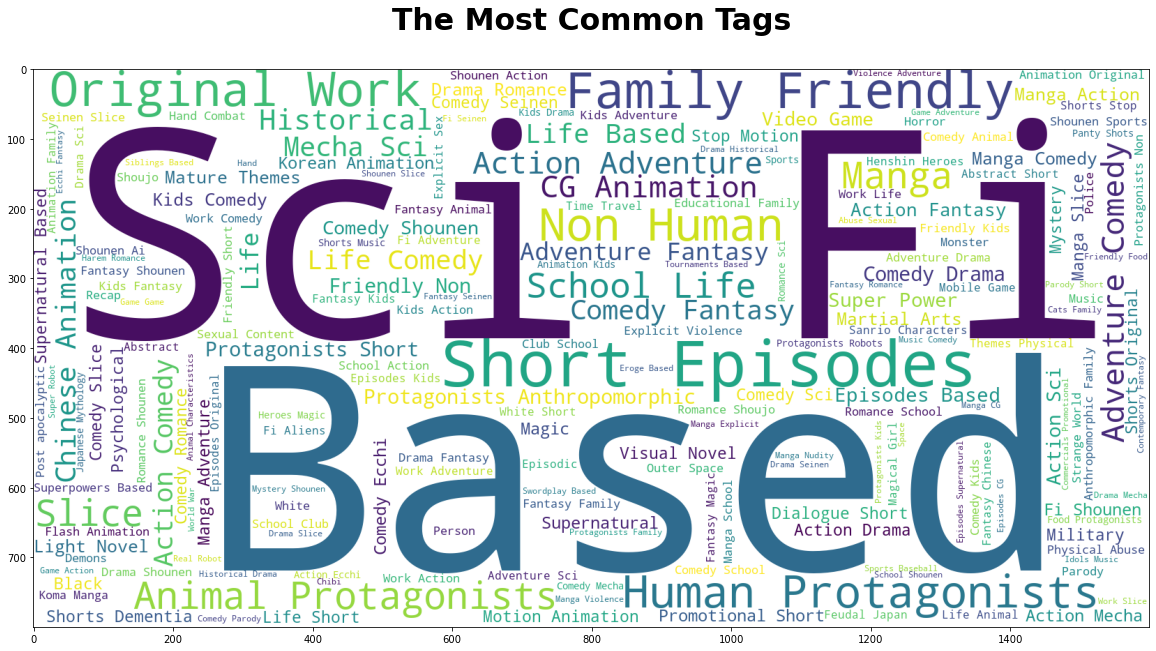

In [91]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Tags\n', fontsize=30, weight=600)
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(short2022["Tags"]))

plt.imshow(wc)

In [92]:
print('Cartoon' in animeplanet_dataset2022['Tags'].unique())

False


In [93]:
short2022[short2022['Tags'].str.contains('Based')]

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type
0,4,5114,Fullmetal Alchemist: Brotherhood,9.0,2009.0,1.0,3,9.0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse, Mature Themes, Violence, Domestic Abuse, Comedy, Magic",TV
1,6,38777,Jujutsu Kaisen,7.0,1010.0,3807.0,4283,7.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen",OVA
2,12,28891,Haikyuu!! Second Season,8.5,2015.0,38.0,94,8.5,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Drama, School, Shounen",TV
3,14,11061,Hunter x Hunter (2011),9.0,2011.0,6.0,12,9.0,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence, Super Power",TV
4,16,37987,Violet Evergarden Movie,8.5,1010.0,55.0,779,8.5,"Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy",Movie
...,...,...,...,...,...,...,...,...,...,...
6673,18180,40568,Yin Yang Shi: Ping An Wu Yu 2nd Season,6.0,1009.5,12996.0,12424,6.0,"Fantasy, Chinese Animation, Short Episodes, Based on a Mobile Game,Slice of Life, Comedy, Historical, Demons, Supernatural",OVA
6683,18277,7625,Yousei Dick,5.0,1992.0,13012.0,12918,5.0,"Fantasy, England, Europe, Family Friendly, Based on a Novel, Kids",TV
6689,18335,25259,Persona 4 the Animation: A Brief Lesson on Izanagi & Izanami,6.0,1006.5,6060.0,6192,6.0,"Based on a Video Game,School",Special
6700,18391,5594,Fuusen no Doratarou,6.0,1981.0,14014.0,14255,6.0,"Comedy, Animal Protagonists, Anthropomorphic, Cats, Family Friendly, Based on a Movie,Kids",TV


In [94]:
short2022[short2022['Tags'].str.contains('Based')]

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type
0,4,5114,Fullmetal Alchemist: Brotherhood,9.0,2009.0,1.0,3,9.0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse, Mature Themes, Violence, Domestic Abuse, Comedy, Magic",TV
1,6,38777,Jujutsu Kaisen,7.0,1010.0,3807.0,4283,7.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen",OVA
2,12,28891,Haikyuu!! Second Season,8.5,2015.0,38.0,94,8.5,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Drama, School, Shounen",TV
3,14,11061,Hunter x Hunter (2011),9.0,2011.0,6.0,12,9.0,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence, Super Power",TV
4,16,37987,Violet Evergarden Movie,8.5,1010.0,55.0,779,8.5,"Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy",Movie
...,...,...,...,...,...,...,...,...,...,...
6673,18180,40568,Yin Yang Shi: Ping An Wu Yu 2nd Season,6.0,1009.5,12996.0,12424,6.0,"Fantasy, Chinese Animation, Short Episodes, Based on a Mobile Game,Slice of Life, Comedy, Historical, Demons, Supernatural",OVA
6683,18277,7625,Yousei Dick,5.0,1992.0,13012.0,12918,5.0,"Fantasy, England, Europe, Family Friendly, Based on a Novel, Kids",TV
6689,18335,25259,Persona 4 the Animation: A Brief Lesson on Izanagi & Izanami,6.0,1006.5,6060.0,6192,6.0,"Based on a Video Game,School",Special
6700,18391,5594,Fuusen no Doratarou,6.0,1981.0,14014.0,14255,6.0,"Comedy, Animal Protagonists, Anthropomorphic, Cats, Family Friendly, Based on a Movie,Kids",TV


In [95]:
#What is this based, lets look into this tag 
based = short2022[short2022['Tags'].str.contains('Based')]
based["Tags"][0]
#based
#Based on a Manga, so lets change it to just plain Manga 

'Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse, Mature Themes, Violence, Domestic Abuse, Comedy, Magic'

In [96]:
based.shape[0]

2580

In [97]:
basedManga = based[based['Tags'].str.contains('Based on a Manga')]
basedManga

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type
0,4,5114,Fullmetal Alchemist: Brotherhood,9.0,2009.0,1.0,3,9.0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Based on a Manga, Animal Abuse, Mature Themes, Violence, Domestic Abuse, Comedy, Magic",TV
1,6,38777,Jujutsu Kaisen,7.0,1010.0,3807.0,4283,7.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Based on a Manga, Explicit Violence,Shounen",OVA
2,12,28891,Haikyuu!! Second Season,8.5,2015.0,38.0,94,8.5,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Based on a Manga,Comedy, Drama, School, Shounen",TV
3,14,11061,Hunter x Hunter (2011),9.0,2011.0,6.0,12,9.0,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Based on a Manga, Violence, Super Power",TV
5,20,39533,Given,8.0,2019.0,214.0,561,8.0,"BL, Drama, Romance, Shounen ai, Death of a Loved One, Music, noitaminA, Based on a Manga, Mature Themes, Suicide,Drama, Shounen Ai, Slice of Life",TV
...,...,...,...,...,...,...,...,...,...,...
6646,17969,20239,Hana no Kakarichou,5.5,1976.0,14255.0,13853,5.5,"Comedy, Slice of Life, Family Life, Based on a Manga, Seinen",TV
6666,18133,23983,Fuichin-san,5.5,1002.0,13982.0,12786,5.5,"Drama, Shoujo, Historical, Based on a Manga, Kids",OVA
6669,18171,33756,Hen Xi You,6.0,1008.0,14370.0,10862,6.0,"Action, Chinese Animation, Supernatural, Based on a Manga, Fantasy",OVA
6671,18177,30839,Big X Episode 0,5.5,0.0,13434.0,15078,5.5,"Action, Sci Fi, Historical, Superpowers, Based on a Manga, Shounen",Special


In [98]:
#A little more than half of it is Based on a Manga, so I'm gonna replace that and find out what the other Based is 
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Manga", "Manga")

In [99]:
based = short2022[short2022['Tags'].str.contains('Based')]
based["Tags"][4]
#next one is Based on a Web Novel, so now we're gonna replace that and turn it to Web - JK after seeing the next one
#which is light novel, it's going to become a novel 

'Drama, Melancholy, War, Based on a Light Novel, Violence,Slice of Life, Drama, Fantasy'

In [100]:
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Web Novel", "Novel")

In [101]:
based = short2022[short2022['Tags'].str.contains('Based')]
based["Tags"][13]

#Based on a Light Novel

'Sci Fi, Conspiracy, LGBT Themes, Psychological, Thriller, Time Travel, Based on a Visual Novel, Mature Themes, Suicide,Thriller, Sci Fi'

In [102]:
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Light Novel", "Novel")

In [103]:
based = short2022[short2022['Tags'].str.contains('Based')]
based["Tags"][47]

'Drama, Mystery, Sci Fi, Psychological, Time Travel, Based on a Visual Novel, Violence,Sci Fi, Thriller'

#### So it looks like there's at lot of based that I am just going to reuse a lot of the code and add what gets changed in the following cells, I just check the output of whatever index has the next Based word in it and change it accordingly 

In [104]:
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Visual Novel", "Novel")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Novel", "Novel")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Video Game", "Game")
short2022["Tags"] = short2022["Tags"].str.replace("Based on an Eroge", "Eroge")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a 4-Koma Manga", "Manga")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Webtoon", "Webtoon")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Cartoon", "Cartoon")
short2022["Tags"] = short2022["Tags"].str.replace("Based on an Otome Game", "Game")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Fairy Tale", "Fantasy")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Card Game", "Game")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Picture Book", "Family Friendly")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a TV Series", "Family Friendly")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Song", "Music")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Movie", "Movie")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Play", "Play")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Comic Book", "Comic")
short2022["Tags"] = short2022["Tags"].str.replace("Based on a Religious Text", "Religion")

# Visualization

#### So now we can look at the new most popular Tags 

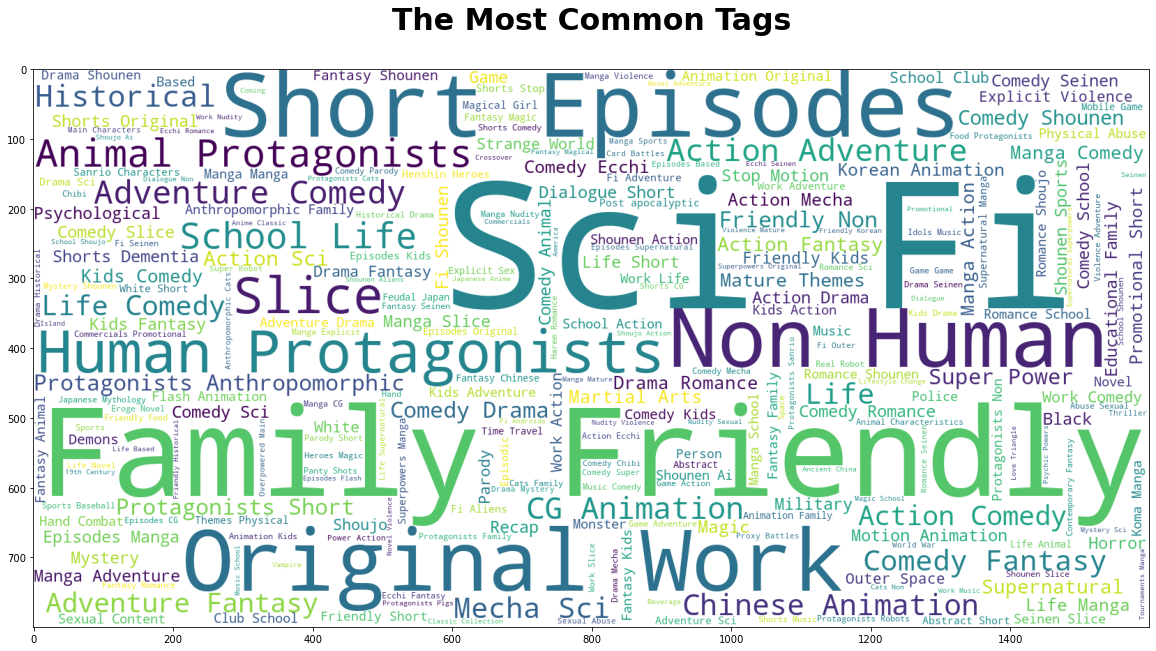

In [105]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Tags\n', fontsize=30, weight=600)
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(short2022["Tags"]))

plt.imshow(wc)

Human Protagonist, SciFi, Family Friendly and NonHumans are the most popular tags from Anime Planet in my first uncombined trial  

But after merging Anime Planet and My Anime List, Comedy, Action and Fantasy were the most popular

In [106]:
genres_list = []
for i in short2022['Tags']:
    genres_list.extend(i.split(', '))
    

Counter(genres_list).most_common(10)

[('Comedy', 2590),
 ('Fantasy', 1487),
 ('Action', 1346),
 ('Sci Fi', 1245),
 ('Drama', 1220),
 ('Adventure', 1061),
 ('Shounen', 1029),
 ('Manga', 965),
 ('Family Friendly', 883),
 ('Short Episodes', 770)]

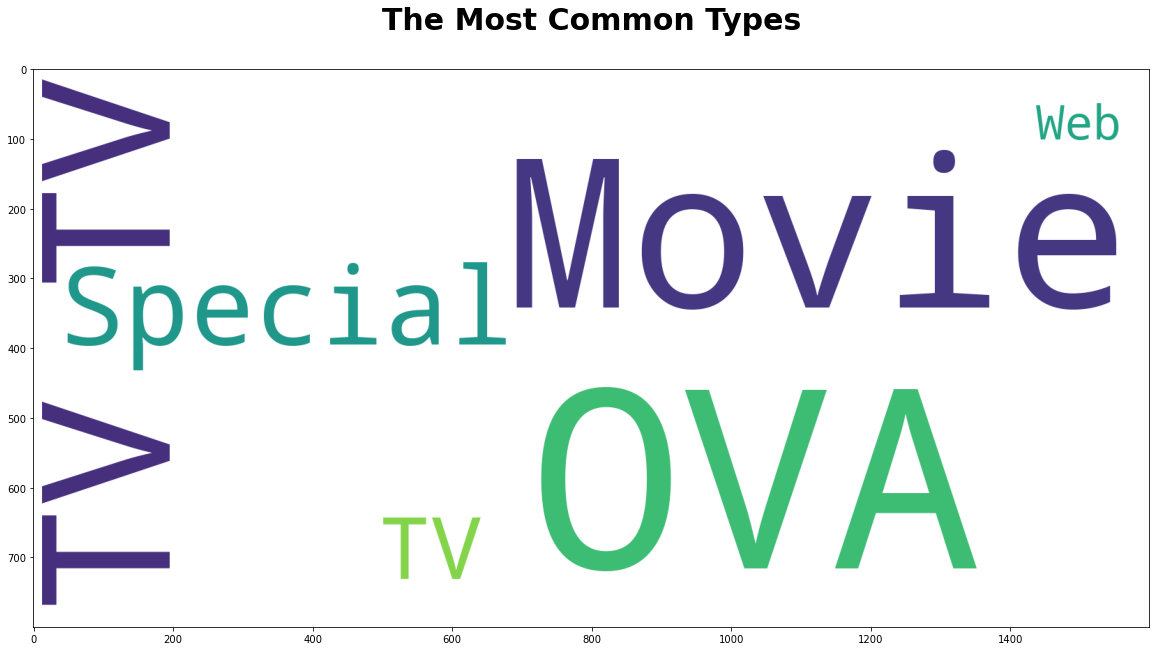

In [107]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Types\n', fontsize=30, weight=600)
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(short2022["Type"]))

plt.imshow(wc)

## Checking out the current Data

In [108]:
short2022

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type
0,4,5114,Fullmetal Alchemist: Brotherhood,9.0,2009.0,1.0,3,9.0,"Action, Adventure, Drama, Fantasy, Mystery, Shounen, Conspiracy, Death of a Loved One, Military, Siblings, Manga, Animal Abuse, Mature Themes, Violence, Domestic Abuse, Comedy, Magic",TV
1,6,38777,Jujutsu Kaisen,7.0,1010.0,3807.0,4283,7.0,"Action, Horror, Shounen, Curse, Exorcists, Monsters, School Life, Supernatural, Manga, Explicit Violence,Shounen",OVA
2,12,28891,Haikyuu!! Second Season,8.5,2015.0,38.0,94,8.5,"Shounen, Sports, School Club, School Life, Tournaments, Volleyball, Manga,Comedy, Drama, School, Shounen",TV
3,14,11061,Hunter x Hunter (2011),9.0,2011.0,6.0,12,9.0,"Action, Adventure, Drama, Fantasy, Shounen, Monsters, Superpowers, Manga, Violence, Super Power",TV
4,16,37987,Violet Evergarden Movie,8.5,1010.0,55.0,779,8.5,"Drama, Melancholy, War, Novel, Violence,Slice of Life, Drama, Fantasy",Movie
...,...,...,...,...,...,...,...,...,...,...
6711,18447,40036,Ometeotl Hero,6.0,1010.0,11328.0,12545,6.0,"Sci Fi, Anime Tamago, Shorts, Superpowers, Original Work,Unknown",Movie
6712,18448,42008,Kin no Makiba,4.5,1000.5,15026.0,17478,4.5,"Fantasy, Animal Protagonists, Non Human Protagonists, Pigs, Shorts, Music",Movie
6713,18451,34472,Geki Drive,4.5,1007.5,14076.0,14429,4.5,"Cars, Promotional, Racing,Action, Cars",OVA
6714,18452,17893,Cheonbangjichuk Hani,6.0,994.0,13571.0,13183,6.0,"Sports, Korean Animation, Running, Track and Field, Comedy, School, Drama",TV


# Done with Cleaning!!!!
# ITS DONNEEEEEEEEE  minus hentai
# Recommendation Time =D  


# Cosine Similarity Recommender System

In [109]:
#All that cleaning, jfc 
#this section will probably be so much shorter

#Convert a collection of text documents to a matrix of token counts. this is to make it easier to convert it into a 
#cosine similarity matrix 

cv = CountVectorizer()
matrix = cv.fit_transform(short2022["Tags"]).toarray()
matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [110]:
similarity = cosine_similarity(matrix)
similarity

array([[1.        , 0.25819889, 0.21821789, ..., 0.07559289, 0.12649111,
        0.10327956],
       [0.25819889, 1.        , 0.50709255, ..., 0.09759001, 0.08164966,
        0.        ],
       [0.21821789, 0.50709255, 1.        , ..., 0.        , 0.41403934,
        0.05634362],
       ...,
       [0.07559289, 0.09759001, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.12649111, 0.08164966, 0.41403934, ..., 0.        , 1.        ,
        0.16329932],
       [0.10327956, 0.        , 0.05634362, ..., 0.        , 0.16329932,
        1.        ]])

In [111]:
def Recommender(user_input):
    
    try:
        anime = short2022[short2022["Name"] == user_input].index[0]
        similarity_score = similarity[anime]
        sorted_scores = sorted(list(enumerate(similarity_score)),reverse = True,key= lambda x: x[1]) [1:11]
        Recommended_Anime = []

        for i in sorted_scores:
            Recommended_Anime.append(short2022.iloc[i[0]].Name)
        return Recommended_Anime
    except IndexError : 
        short2022[short2022['Name'].str.contains(user_input)]
        print("Name not exist")

In [112]:
short2022[short2022['Name'].str.contains('labyrinth')]

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type


In [113]:
Recommender("Jujutsu Kaisen")
#before removing other genres 
#Eve : KaiKai Kitan - Song
# Dark Cat brothers fighting tentacle demon
#Ga-Rei-Zero - lesbian demon slayer
# Thus Spoke Kishibe Rohan - Jojo Bizarre's Adventure Spinoff
# Tokyo Ghoul: Jack - Tokyo Ghoul Spinoff
# Hell Teacher Nube: Gozen 0 Toki Nube Shisu - old movie
# Zombie-Loan - looks so old 
# Toilet-Bound Hanako-kun - 2014 demon school shenenigans


#After removing music
# Jujutsu Kaisen',
#  'Jujutsu Kaisen 0',
#  'Dark Cat',
#  'Ga-Rei-Zero',
#  'Thus Spoke Kishibe Rohan',
#  'Tokyo Ghoul: Jack',
#  'Hell Teacher Nube: Gozen 0 Toki Nube Shisu',
#  'Zombie-Loan',
#  'Toilet-Bound Hanako-kun',
#  'Angel Densetsu

#so these options are weird, I want to do a relevant and classical recommender, so i Need to separate them based on years


#after merging mal and anime planet
# ['Ushiro no Hyakutarou',
#  'Koukou Butouden Crows',
#  'Zombie-Loan',
#  'World Trigger',
#  'Zombie-Loan Specials',
#  'Angel Densetsu',
#  'Play Ball 2nd',
#  'Play Ball',
#  "I'll/CKBC",
#  'Dark Cat']

['Ushiro no Hyakutarou',
 'Koukou Butouden Crows',
 'Zombie-Loan',
 'World Trigger',
 'Zombie-Loan Specials',
 'Angel Densetsu',
 'Play Ball 2nd',
 'Play Ball',
 "I'll/CKBC",
 'Dark Cat']

In [190]:
short2022[short2022['Name'].str.contains('Kabaneri')]

,Rank,MAL_ID,Name,Rating,Release Year,Ranked,Popularity,Rating,Tags,Type


In [199]:
pd.DataFrame(Recommender("Samurai Champloo")).set_index(0)

""
0
Haikyuu!! Movie 1: Owari to Hajimari
Haikyuu!! Second Season
Haikyuu!!
Yowamushi Pedal: Grande Road
Yowamushi Pedal
Yowamushi Pedal: Spare Bike
Yowamushi Pedal: Re:ROAD
Yowamushi Pedal: Re:RIDE
Dear Boys


# Scikit Surprise Method

In [200]:
#https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration
#code gives you step by step instructions 
anime_name = dict()
index = 0
#get the names individually 
for ani_ID , ani_name in zip(surprise_filter['MAL_ID'].unique(),surprise_filter['Name'].unique()):
    anime_name[index] = ani_name
    index = index + 1
    

index=0
new_names = dict()
for ani_ID , ani_name in anime_name.items():
    new_names[ani_name]= ani_ID

In [201]:
training_set = surprise_filter.drop('Name',axis=1)

In [202]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(training_set, reader=reader)

trainset = data.build_full_trainset()

In [259]:
#https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration

sim_options = {
    "name": "cosine",
    "user_based": False,  # compute  similarities between items
}

algo = KNNBasic(sim_options=sim_options)
similarity_matrix = algo.fit(trainset).compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [260]:
similarity_matrix

array([[1.        , 0.96855783, 0.9751714 , ..., 0.96503561, 0.97584839,
        0.96539922],
       [0.96855783, 1.        , 0.96160395, ..., 0.97135098, 0.96780489,
        0.96460176],
       [0.9751714 , 0.96160395, 1.        , ..., 0.96994176, 0.97105234,
        0.96481557],
       ...,
       [0.96503561, 0.97135098, 0.96994176, ..., 1.        , 0.97360991,
        0.96972272],
       [0.97584839, 0.96780489, 0.97105234, ..., 0.97360991, 1.        ,
        0.96139152],
       [0.96539922, 0.96460176, 0.96481557, ..., 0.96972272, 0.96139152,
        1.        ]])

In [311]:
def surprise_recommender(user_input):
    
    try:
        anime = new_names[ani_name]
        Similarity_score = similarity_matrix[anime]
        Sorted_scores = sorted(list(enumerate(Similarity_score)),reverse = True ,key= lambda x: x[1]) [1:11]
        Recommended_Anime = []

        for i in Sorted_scores:
            Recommended_Anime.append(anime_name[i[0]])
        return Recommended_Anime
    
        
    except IndexError : 
        #short2022[short2022['Name'].str.contains(user_input)]
        print("Name not exist")

In [312]:
pd.DataFrame(surprise_recommender("Pokemon")).set_index(0)

""
0
Taisei Kensetsu: Shin Doha Kokusai Kuukou
Gintama: Shinyaku Benizakura-hen
Major: World Series
Kyoukai no Rinne (TV) 3rd Season
Cardfight!! Vanguard
DNA² OVA
Majutsushi Orphen
Mobile Suit Gundam: The 08th MS Team - A Battle with the Third Dimension
Ginga Nagareboshi Gin


In [263]:
surprise_recommender('Hunter x Hunter')

['Rifle Is Beautiful',
 'Galaxy Angel Z',
 'Tetsuwan Atom (1980)',
 'Daa! Daa! Daa!',
 'Levius',
 'Kengan Ashura 2nd Season',
 'Oh! Edo Rocket',
 'New Initial D Movie: Legend 3 - Mugen',
 'Telepathy Shoujo Ran',
 'Nodame Cantabile: Finale - Mine to Kiyora no Saikai']

# TensorFlow Method

In [140]:
#https://www.tensorflow.org/recommenders/examples/basic_ranking the whole code is here that i just used

surprise_filter['User_ID'] = surprise_filter['User_ID'].astype(str)

#The method tf.data.Dataset.from_tensor_slices was used to slice up the data into the form of objects for both ratings of 
#user IDs and anime. This makes it easier to fit and evaluate the model

ratings = tf.data.Dataset.from_tensor_slices(dict(surprise_filter[['User_ID', 'Name', 'Rating']]))
anime = tf.data.Dataset.from_tensor_slices(dict(surprise_filter[['Name']]))

ratings = ratings.map(lambda x: {
    "Name": x["Name"],
    "User_ID": x["User_ID"],
    "Rating": float(x["Rating"])
})

anime = anime.map(lambda x: x["Name"])

In [141]:
print('Total Data:', (len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
      
 #splitting into test/train split 80/20    

train = ratings.take(80_000)
test = ratings.skip(80_000).take(20_000)

Total Data: 17764154


In [142]:
anime_titles = anime.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["User_ID"])

unique_anime_titles = np.unique(np.concatenate(list(anime_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Anime:',(len(unique_anime_titles)))
print('Unique users:',(len(unique_user_ids)))

Unique Anime: 5670
Unique users: 23004


In [143]:
class AnimeModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

        super().__init__()

        #increased dimensions from 32 -> 64 
        embedding_dimension = 64

        # User and anime models.
        #Keras preprocessing layers to first convert user ids to integers, and then convert those to user embeddings via an 
        #Embedding layer. Note that we use the list of unique user ids we computed earlier as a vocabulary:
        self.anime_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_anime_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_anime_titles) + 1, embedding_dimension)
        ])
            #user
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and anime embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The metrics for getting MSE and accuracy 
        
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=anime.batch(128).map(self.anime_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["User_ID"])
        # And pick out the anime features and pass them into the anime model.
        anime_embeddings = self.anime_model(features["Name"])

        return (
            user_embeddings,
            anime_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and anime embeddings.
            self.rating_model(
                tf.concat([user_embeddings, anime_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ratings = features.pop("Rating")

        user_embeddings, anime_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, anime_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

In [ ]:
model = AnimeModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(1_000).cache()
cached_test = test.batch(1_000).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
 2/80 [..............................] - ETA: 63:02:15 - root_mean_squared_error: 6.9337 - factorized_top_k/top_1_categorical_accuracy: 0.0040 - factorized_top_k/top_5_categorical_accuracy: 0.0040 - factorized_top_k/top_10_categorical_accuracy: 0.0040 - factorized_top_k/top_50_categorical_accuracy: 0.0040 - factorized_top_k/top_100_categorical_accuracy: 0.0040 - loss: 6955.6179 - regularization_loss: 0.0000e+00 - total_loss: 6955.6179                    

In [ ]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

In [ ]:
def predict_anime(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends anime out of the entire anime dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((anime.batch(100), anime.batch(100).map(model.anime_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, anime):
    trained_anime_embeddings, trained_user_embeddings, predicted_rating = model({
          "User_ID": np.array([str(user)]),
          "Name": np.array([anime])
      })
    print("Predicted rating for {}: {}".format(anime, predicted_rating.numpy()[0][0]))

In [ ]:
#this gets it based on user ID's and gets habit into a future recommendation 

In [ ]:
predict_anime(42, 10)

In [ ]:
predict_rating(42, "Jujutsu Kaisen")

In [ ]:
# Get meta data for predicted anime
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends anime out of the entire anime dataset.
index.index_from_dataset(tf.data.Dataset.zip((anime.batch(50), anime.batch(50).map(model.anime_model))))

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_anime = pd.DataFrame({'Name': [i.decode('utf-8') for i in titles[0,:10].numpy()]})

pred_df = pred_anime.merge(short2022[['Name', 'Tags']], on='Name', how='left')
pred_df = pred_df[~pred_df['Name'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df